# Implémentation d'un ResNet

Pour pouvoir implémenter un ResNet, il faut d'abord savoir construire une couche simple d'un réseau de neurones: elle prend en entrée un input, le multiplie par un vecteur de poids, y ajoute un biais, applique une fonction d'activation et retourne le résultat.

La fonction suivante va donc définir un perceptron à plusieurs couches.

In [3]:
import jax.numpy as jnp

def mlp(params, inputs):
    for w, b in params:
        outputs = jnp.dot(inputs, w) + b
        inputs = jnp.tanh(outputs)
    return outputs

Les paramètres de cette fonction mlp sont une liste de matrices avec les poids de chaques couches et une liste de vecteurs contenant les biais.

Pour faire des modèles plus grands, on peut concaténer plusieurs mlp, tout en rajoutant à chacun de leur output l'input précédent: on obtient ainsi un ResNet.

In [4]:
def resnet(params, inputs, depth):
    for i in range(depth):
        outputs = mlp(params, inputs) + inputs
    return outputs

Pour pouvoir utiliser ce modèle avec des données et l'entrainer, on a aussi besoin d'une loss function, une fonction qui initialise les paramètres du modèle au départ et d'une fonction qui met à jour ces paramètres lors de l'entrainement.

In [42]:
import numpy.random as npr
from jax.api import jit, grad

resnet_depth = 3
def resnet_squared_loss(params, inputs, targets):
    preds = resnet(params, inputs, resnet_depth)
    return jnp.mean(jnp.sum((preds - targets)**2, axis=1))

def init_random_params(scale, layer_sizes, rng=npr.RandomState(0)):
    return [(scale * rng.randn(m,n), scale * rng.randn(n)) for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

@jit
def resnet_update(params, inputs, targets):
    grads = grad(resnet_squared_loss)(params, inputs, targets)
    return [(w - step_size * dw, b - step_size * db) for (w, b), (dw, db) in zip(params, grads)]

Nous pouvons maintenant tester ce modèle sur un ensemble de données simple: des points dans le plan. 
On peut générer aléatoirement des points suivant une courbe, puis entrainer le modèle sur ces données afin d'approximer cette courbe.

0.13927937


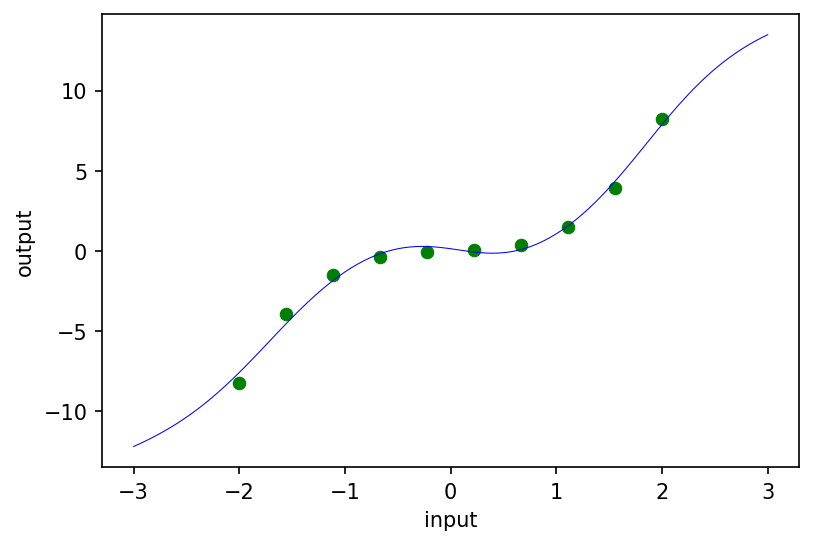

In [49]:
import matplotlib.pyplot as plt

# Génération de l'ensemble des données pour l'entrainement
# C'est-à-dire des inputs étant des réels, ainsi que leur # output associé, c'est-à-dire leur image pas la fonction # représentant la courbe (x³ + 0.1.x)
inputs = jnp.reshape(jnp.linspace(-2.0, 2.0, 10), (10, 1))
targets = inputs**3 + 0.1 * inputs

# Hyperparamètres des couches
layer_sizes = [1, 20, 1]
param_scale = 1
step_size = 0.01
train_iters = 1000

# Initialise les poids et biais des couches 
# et entraine le modèle
resnet_params = init_random_params(param_scale, layer_sizes)
for i in range(train_iters):
  resnet_params = resnet_update(resnet_params, inputs, targets)

# Affiche les résultats
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca()
ax.scatter(inputs, targets, lw=0.5, color='green')
fine_inputs = jnp.reshape(jnp.linspace(-3.0, 3.0, 100), (100, 1))
ax.plot(fine_inputs, resnet(resnet_params, fine_inputs, resnet_depth), lw=0.5, color='blue')
ax.set_xlabel('input')
ax.set_ylabel('output')

print(resnet_squared_loss(resnet_params, inputs, targets))